# Preliminary Strain Calculations in the LIT-PCBA Dataset

* Protein: Opioid Kappa Receptor 1
* PDB: 67B3
* Protein Preparation: Default
* Grid: Default 
* Ligands: Full Dataset
* Ligand Preparation: Default 
* Docking: Glide (default) 

In [51]:
import pandas as pd
import pickle
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc  # Importing the auc function

In [12]:
def load_sdf_to_dataframe(filename, active):
    """
    Load molecules and their properties from an SDF file into a DataFrame.
    
    This is very inefficient and should only be used for small datasets.
    I will rewrite this in the future to use a more efficient method.
    Likely by `parallel` in bash and saving the pickle file. 

    Parameters:
    filename (str): The path to the SDF file.
    active (bool): Flag indicating whether the molecules are active or not.

    Returns:
    pandas.DataFrame: The DataFrame containing the loaded molecules and their properties.
    """
    # Create a molecule supplier
    mol_supplier = Chem.SDMolSupplier(filename)

    # Load the molecules and their properties into a list
    molecules = []
    for mol in mol_supplier:
        if mol is not None:
            props = mol.GetPropsAsDict()
            props['Title'] = mol.GetProp('_Name')
            props['Mol'] = mol
            props['Activity'] = 1 if active else 0
            molecules.append(props)

    # Convert the list into a DataFrame
    df = pd.DataFrame(molecules)

    # Reorder the DataFrame columns
    cols = ['Title', 'Mol', 'Activity'] + [col for col in df.columns if col not in ['Title', 'Mol', 'Activity']]
    df = df[cols]

    return df

# Usage:
#active = load_sdf_to_dataframe('67B3_actives.sdf', active=True)
#inactive = load_sdf_to_dataframe('67B3_inactives.sdf', active=False)

[22:49:05] Explicit valence for atom # 16 N, 4, is greater than permitted
[22:49:05] ERROR: Could not sanitize molecule ending on line 197257
[22:49:05] ERROR: Explicit valence for atom # 16 N, 4, is greater than permitted
[22:49:30] Explicit valence for atom # 14 N, 4, is greater than permitted
[22:49:30] ERROR: Could not sanitize molecule ending on line 375732
[22:49:30] ERROR: Explicit valence for atom # 14 N, 4, is greater than permitted
[22:51:11] Explicit valence for atom # 15 N, 4, is greater than permitted
[22:51:11] ERROR: Could not sanitize molecule ending on line 1092108
[22:51:11] ERROR: Explicit valence for atom # 15 N, 4, is greater than permitted
[22:53:18] Explicit valence for atom # 15 N, 4, is greater than permitted
[22:53:18] ERROR: Could not sanitize molecule ending on line 1970527
[22:53:18] ERROR: Explicit valence for atom # 15 N, 4, is greater than permitted
[22:53:41] Explicit valence for atom # 15 N, 4, is greater than permitted
[22:53:41] ERROR: Could not sani

In [13]:
def save_to_pickle(df, filename):
    with open(filename, 'wb') as f:
        pickle.dump(df, f)

# Usage:
#save_to_pickle(active, '67B3_actives.pkl')
#save_to_pickle(inactive, '67B3_inactives.pkl')

Making rdkit mol objects from the SDF takes a long time. 

`./multi_sdsubset.sh` is a hardcoded script to split the `67B3_inactives.sdf` (~500K) into 10 parts (~50K) using Schrodinger tools. The command runs in parallel via & oeprators. 

`./multi_torsion_strain.sh` is a hardcoded script to take those `subset_*.sdf` that runs in parallel via the `parallel` functionality via `brew install parallel`. It runs my refactored torsion strain script to write the torsion csv files. 

Now we can load the csv files. We will start with the inactives:

In [14]:
def concatenate_csv_files(file_list):
    """
    Concatenates multiple strain CSV files into a single dataframe.
    Only the first five columns are kept for now. 

    Args:
        file_list (list): A list of file paths to the CSV files.

    Returns:
        pandas.DataFrame: The concatenated dataframe.

    """
    # Specify the column names
    column_names = [
        "Molecule_Name",
        "Total_E",
        "Lower_Bound",
        "Upper_Bound",
        "Num_Torsion_Patterns",
    ]

    # List to hold dataframes
    df_list = []

    # Loop over each file in the list
    for file in file_list:
        # Import the CSV file as a df, using only the first five columns of the CSV file
        df = pd.read_csv(file, usecols=range(5), names=column_names, header=0)
        df_list.append(df)

    # Concatenate all dataframes in the list
    final_df = pd.concat(df_list, ignore_index=True)

    return final_df

In [22]:
import glob

# Use glob to get csv files ('subset_*.csv) from the directory
csv_files = glob.glob("subset_*.csv")

# Sort the list of files by the number in their names
csv_files.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))

# Check the order
print(csv_files)

# Concatenate the CSV files
OPRK1_inactives_strain = concatenate_csv_files(csv_files)

# Molecule_Name is being read as a float, so convert it to a string
OPRK1_inactives_strain["Molecule_Name"] = OPRK1_inactives_strain["Molecule_Name"].astype(str)

# Display the first five rows
display(OPRK1_inactives_strain.head())

# Display summary statistics, rounded to one decimal places
display(OPRK1_inactives_strain.describe().round(1))

['subset_1.csv', 'subset_2.csv', 'subset_3.csv', 'subset_4.csv', 'subset_5.csv', 'subset_6.csv', 'subset_7.csv', 'subset_8.csv', 'subset_9.csv', 'subset_10.csv']


,Molecule_Name,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns
0,17407344,10.874642,8.114060,NaN,1.0
1,24784061,11.043108,10.040673,NaN,7.0
2,17407000,11.432821,7.485982,NaN,1.0
3,47201060,5.091219,4.529746,5.913435,4.0
4,22409465,6.849733,5.756975,NaN,5.0


,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns
count,528089.0,528089.0,269569.0,528089.0
mean,5.8,4.7,inf,2.7
std,3.3,2.6,NaN,2.2
min,-2.0,-0.1,0.0,0.0
25%,3.4,2.8,2.8,1.0
50%,5.4,4.4,4.6,2.0
75%,7.8,6.3,7.7,4.0
max,30.9,23.3,inf,18.0


Now we will load the actives in a similar way. 

In [23]:
# We can still use concatenate_csv_files() to read in the active strain data
OPRK1_actives_strain = concatenate_csv_files(["67B3_actives.csv"])

# Molecule_Name is being read as a float, so convert it to a string
OPRK1_actives_strain["Molecule_Name"] = OPRK1_actives_strain["Molecule_Name"].astype(str)

# Display the first five rows
display(OPRK1_actives_strain.head())

# Display summary statistics, rounded to one decimal places
display(OPRK1_actives_strain.describe().round(1))


,Molecule_Name,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns
0,14742361,7.743401,6.452040,NaN,4
1,14721919,9.862600,7.793637,NaN,1
2,14733740,9.336486,7.212523,NaN,8
3,51085197,7.962479,6.610545,inf,2
4,11532953,7.557015,5.150796,NaN,0


,Total_E,Lower_Bound,Upper_Bound,Num_Torsion_Patterns
count,38.0,38.0,14.0,38.0
mean,7.2,5.8,inf,3.1
std,2.8,2.3,NaN,2.4
min,0.9,0.7,1.2,0.0
25%,5.8,4.9,2.8,1.0
50%,8.2,6.8,3.2,2.5
75%,9.3,7.6,7.1,4.0
max,10.5,8.8,inf,8.0


Now let's clean up the docking data so we can merge this. 

In [26]:
# We have already loaded the docking data into dataframes: active and inactive

# Convert the 'Title' column to a string in both dataframes
active["Title"] = active["Title"].astype(str)
inactive["Title"] = inactive["Title"].astype(str)

# Rename the 'Title' column to 'Molecule_Name' in both dataframes
active.rename(columns={"Title": "Molecule_Name"}, inplace=True)
inactive.rename(columns={"Title": "Molecule_Name"}, inplace=True)
# Merge the strain data for the active and inactive datasets as a deep copy 
# so that the original dataframes are not modified
active_data = active.merge(OPRK1_actives_strain, how="left", on="Molecule_Name").copy(deep=True)
inactive_data = inactive.merge(OPRK1_inactives_strain, how="left", on="Molecule_Name").copy(deep=True)

# Display the first five rows of the active_data dataframe
display(active_data.head())
# Display the first five rows of the inactive_data dataframe
display(inactive_data.head())

# Concatenate the active and inactive dataframes as "all_data"
all_data = pd.concat([active_data, inactive_data], ignore_index=True)

# Display the first five rows of the all_data dataframe
display(all_data.head())

In [31]:
# Make a subset of all_data containing these columns: 'Molecule_Name', 'Mol', 'Activity', 'r_i_docking_score', 'Total_E', 'Lower_Bound', 'Upper_Bound'
all_data_subset = all_data[['Molecule_Name', 'Mol', 'Activity', 'r_i_docking_score', 'Total_E', 'Lower_Bound', 'Upper_Bound']].copy(deep=True)
all_data_subset

,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound
0,49819640,<rdkit.Chem.rdchem.Mol object at 0x16b9b33e0>,1,-8.36082,5.802496,4.853557,7.136432
1,49819640,<rdkit.Chem.rdchem.Mol object at 0x16b9b33e0>,1,-8.36082,5.802496,4.853557,7.136432
2,49819640,<rdkit.Chem.rdchem.Mol object at 0x16b9b33e0>,1,-8.36082,5.802496,4.853557,7.136432
3,14742361,<rdkit.Chem.rdchem.Mol object at 0x16b9b3450>,1,-8.31699,7.743401,6.452040,NaN
4,14721919,<rdkit.Chem.rdchem.Mol object at 0x16b9b2dc0>,1,-7.92756,9.862600,7.793637,NaN
...,...,...,...,...,...,...,...
2296862,17412195,<rdkit.Chem.rdchem.Mol object at 0x68df39b60>,0,2.44014,10.717299,8.919937,NaN
2296863,26662803,<rdkit.Chem.rdchem.Mol object at 0x68df39c40>,0,2.56724,11.944859,10.980150,NaN
2296864,26662803,<rdkit.Chem.rdchem.Mol object at 0x68df39c40>,0,2.56724,11.944859,10.980150,NaN
2296865,26662803,<rdkit.Chem.rdchem.Mol object at 0x68df39c40>,0,2.56724,11.944859,10.980150,NaN


First pass at enrichment metrics, not familiar with this.

In [52]:
# Sort the subset by 'r_i_docking_score' in ascending order
all_data_subset.sort_values(by="r_i_docking_score", inplace=True)

# Reset the index so that we are ranking by the docking score
all_data_subset.reset_index(drop=True, inplace=True)

# Add 1 to the index so we can take a log later
all_data_subset.index += 1  # Adjusting the index to start from 1

# Calculate the cumulative sum of active compounds
# (i.e. the number of active compounds at each row)
all_data_subset["Cumulative_Actives"] = all_data_subset["Activity"].cumsum()

# Calaulate the Total Actives (i.e. the total number of active compounds)
# This is a constant value, unlike cumsum
all_data_subset["Total_Actives"] = all_data_subset["Activity"].sum()

# Calculate the fraction of identified actives at each row
# This column progresses from 0 to 1 as actives are identified
all_data_subset["Fraction_Actives"] = (
    all_data_subset["Cumulative_Actives"] / all_data_subset["Total_Actives"]
)

# Calculate the logarithm of the ranking at each row, via the index
# This for the 'log' part of LogAUC 
all_data_subset["Log_Fraction_Actives"] = np.log1p(all_data_subset.index)

# Calculate the logAUC
log_auc = auc(all_data_subset["Log_Fraction_Actives"], all_data_subset["Fraction_Actives"])

all_data_subset

,Molecule_Name,Mol,Activity,r_i_docking_score,Total_E,Lower_Bound,Upper_Bound,Cumulative_Actives,Total_Actives,Fraction_Actives,Log_Fraction_Actives
1,17509036,<rdkit.Chem.rdchem.Mol object at 0x16b9b2c70>,0,-11.37900,12.383258,10.774766,inf,0,79,0.0,0.693147
2,17407344,<rdkit.Chem.rdchem.Mol object at 0x16b9b23b0>,0,-11.05610,13.079049,10.251546,NaN,0,79,0.0,1.098612
3,17407344,<rdkit.Chem.rdchem.Mol object at 0x16b9b23b0>,0,-11.05610,10.874642,8.114060,NaN,0,79,0.0,1.386294
4,24784061,<rdkit.Chem.rdchem.Mol object at 0x16b9b2490>,0,-10.92740,11.043108,10.040673,NaN,0,79,0.0,1.609438
5,24784061,<rdkit.Chem.rdchem.Mol object at 0x16b9b2490>,0,-10.92740,11.043108,10.040673,NaN,0,79,0.0,1.791759
...,...,...,...,...,...,...,...,...,...,...,...
2296863,17412195,<rdkit.Chem.rdchem.Mol object at 0x68df39b60>,0,2.44014,10.717299,8.919937,NaN,79,79,1.0,14.647055
2296864,26662803,<rdkit.Chem.rdchem.Mol object at 0x68df39c40>,0,2.56724,11.944859,10.980150,NaN,79,79,1.0,14.647056
2296865,26662803,<rdkit.Chem.rdchem.Mol object at 0x68df39c40>,0,2.56724,11.944859,10.980150,NaN,79,79,1.0,14.647056
2296866,26662803,<rdkit.Chem.rdchem.Mol object at 0x68df39c40>,0,2.56724,11.944859,10.980150,NaN,79,79,1.0,14.647057


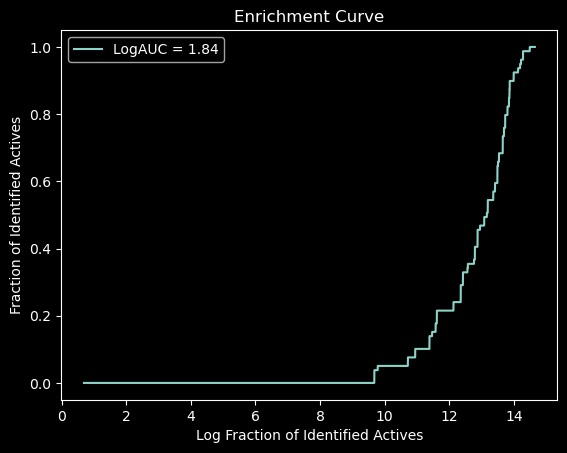

In [55]:
# Plot the logAUC
plt.plot(
    all_data_subset["Log_Fraction_Actives"],
    all_data_subset["Fraction_Actives"],
    label="LogAUC = {:.2f}".format(log_auc),
)

# Add axis labels and title
plt.xlabel("Log Fraction of Identified Actives")
plt.ylabel("Fraction of Identified Actives")
plt.title("Enrichment Curve")

plt.legend()
plt.show()


Now I need to figure out how the authors calculated their &Delta;LogAUC